### Demand Forecasting Example Using Limited Data (14 Months) with CastBoost


This notebook presents a demand forecasting approach based on just 14 months of historical data. The goal is to predict demand 28 days ahead using model: CastBoost.


##### Loading libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
from sklearn.metrics import mean_squared_error, r2_score
import joblib
# Mostrar todas las columnas
pd.set_option('display.max_columns', None)

# (Opcional) También puedes querer ver todas las filas:
# pd.set_option('display.max_rows', None)

# Y ampliar el ancho del contenido si tienes columnas largas
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)  # Para no truncar texto largo


In [2]:
le = LabelEncoder()
# --- 1. Data Loading and Initial Preprocessing ---

# Load the reservations dataset
reservations_df = pd.read_csv('reservations_mod.csv')
reservations_df.drop(['reservation_id', 'category_id'], axis=1, inplace=True)

# Identify confirmed vs. cancelled reservations
# Convert cancellation_date to boolean.
reservations_df['is_cancelled'] = reservations_df['cancellation_date'].notna()
reservations_df['checkin_date_'] = reservations_df['checkin_date']

reservations_df.set_index('checkin_date', inplace=True)
reservations_df.sort_index(inplace=True)

reservations_df

,category_capacity,category_bedrooms,category_bathrooms,city,checkout_date,reservation_date,cancellation_date,is_cancelled,checkin_date_
checkin_date,,,,,,,,,
2019-01-01,8,4,3,Málaga,2019-01-03,2020-12-31,NaN,False,2019-01-01
2019-01-01,5,2,2,Málaga,2019-01-02,2020-12-29,NaN,False,2019-01-01
2019-01-01,5,2,2,Málaga,2019-01-03,2020-12-27,NaN,False,2019-01-01
2019-01-01,7,3,2,Málaga,2019-01-02,2019-01-01,NaN,False,2019-01-01
2019-01-01,7,3,2,Málaga,2019-01-02,2020-12-31,NaN,False,2019-01-01
...,...,...,...,...,...,...,...,...,...
2020-02-29,5,3,2,Mallorca,2020-03-05,2020-01-23,NaN,False,2020-02-29
2020-02-29,7,3,2,Málaga,2020-03-01,2020-02-29,NaN,False,2020-02-29
2020-02-29,7,3,2,Mallorca,2020-03-02,2020-02-13,2020-02-13,True,2020-02-29


In [3]:
# Convert specified columns to datetime objects for easier date manipulation
date_columns = ['checkin_date_', 'checkout_date', 'reservation_date', 'cancellation_date']
for col in date_columns:
    reservations_df[col] = pd.to_datetime(reservations_df[col])

# Create a new 'room_type' feature by combining category-related features as strings
# This forms a unique identifier for each room type based on its capacity, number of bedrooms, and bathrooms
reservations_df['room_type'] = reservations_df['category_capacity'].astype(str) + '_' + \
                               reservations_df['category_bedrooms'].astype(str) + '_' + \
                               reservations_df['category_bathrooms'].astype(str)

# Encode the combined 'room_type' string into numerical labels using a label encoder (le)
reservations_df['room_type'] = le.fit_transform(reservations_df['room_type'])

# Calculate and print the number of unique room types in the dataset
room_type = len(reservations_df['room_type'].unique())
print(f'Number of room types: {room_type}')


Number of room types: 5


In [4]:
# Create new features derived from the 'checkin_date_' column for time-based analysis

# Calculate the duration of each stay in days by subtracting check-in from check-out
reservations_df['duration_of_stay'] = (reservations_df['checkout_date'] - reservations_df['checkin_date_']).dt.days

# Extract the day of the week (0=Monday to 6=Sunday) and add 1 to make it 1-based (1=Monday)
reservations_df['checkin_day_of_week'] = reservations_df['checkin_date_'].dt.dayofweek + 1

# Extract the month (1 to 12) from the check-in date
reservations_df['checkin_month'] = reservations_df['checkin_date_'].dt.month

# Extract the ISO week number of the year from the check-in date
reservations_df['checkin_week_of_year'] = reservations_df['checkin_date_'].dt.isocalendar().week.astype(int)

# Extract the day of the month (1 to 31) from the check-in date
reservations_df['checkin_day_of_the_month'] = reservations_df['checkin_date_'].dt.day

# Extract the year from the check-in date
reservations_df['checkin_year'] = reservations_df['checkin_date_'].dt.year

# Calculate "lead time": the number of days between reservation date and check-in date
# Missing values are filled with 0
reservations_df['lead_time'] = (reservations_df['checkin_date_'] - reservations_df['reservation_date']).dt.days.fillna(0)

# Ensure that lead_time is not negative (e.g., if reservation date is after check-in date)
reservations_df['lead_time'] = reservations_df['lead_time'].apply(lambda x: max(0, x))

# Display the first 10 records for reservations made in the city of Málaga
reservations_df[reservations_df['city'] == 'Málaga'].head(10)


,category_capacity,category_bedrooms,category_bathrooms,city,checkout_date,reservation_date,cancellation_date,is_cancelled,checkin_date_,room_type,duration_of_stay,checkin_day_of_week,checkin_month,checkin_week_of_year,checkin_day_of_the_month,checkin_year,lead_time
checkin_date,,,,,,,,,,,,,,,,,
2019-01-01,8,4,3,Málaga,2019-01-03,2020-12-31,NaT,False,2019-01-01,4,2,2,1,1,1,2019,0
2019-01-01,5,2,2,Málaga,2019-01-02,2020-12-29,NaT,False,2019-01-01,0,1,2,1,1,1,2019,0
2019-01-01,5,2,2,Málaga,2019-01-03,2020-12-27,NaT,False,2019-01-01,0,2,2,1,1,1,2019,0
2019-01-01,7,3,2,Málaga,2019-01-02,2019-01-01,NaT,False,2019-01-01,3,1,2,1,1,1,2019,0
2019-01-01,7,3,2,Málaga,2019-01-02,2020-12-31,NaT,False,2019-01-01,3,1,2,1,1,1,2019,0
2019-01-01,7,3,2,Málaga,2019-01-02,2020-12-31,NaT,False,2019-01-01,3,1,2,1,1,1,2019,0
2019-01-01,8,4,3,Málaga,2019-01-05,2020-11-29,NaT,False,2019-01-01,4,4,2,1,1,1,2019,0
2019-01-01,7,3,2,Málaga,2019-01-02,2019-01-01,NaT,False,2019-01-01,3,1,2,1,1,1,2019,0
2019-01-01,7,3,2,Málaga,2019-01-02,2020-12-17,NaT,False,2019-01-01,3,1,2,1,1,1,2019,0


In [5]:
import plotly.express as px

fig = px.histogram(
    reservations_df,
    x='lead_time',
    nbins=200,  # ajusta la cantidad de bins según tu rango de valores
    title='Distribución del tiempo en días entre reserva y checkin',
    labels={'lead_time': 'Tiempo de espera'},
    color_discrete_sequence=['royalblue']
)

fig.update_layout(template='plotly_white')
fig.show()

   ## Insights

### Heavily Right-Skewed Distribution
- The majority of reservations occur with short lead times (between 0 and ~20 days).
- There's a sharp drop-off in frequency as lead time increases.

### Most Common Lead Times
- The peak occurs at **0–5 days**, indicating many guests book very close to their check-in date (possibly last-minute bookings).
- A significant tail extends up to **over 300 days**, but very few bookings are made that far in advance.


In [6]:
# Create the target variable: number of reservations (demand) per check-in date, city, and room type

# Group the reservations by 'checkin_date_', 'city', and 'room_type'
# Then sum the 'category_capacity' to represent total demand (e.g., number of rooms) for each group
df_demand_day = reservations_df.groupby(['checkin_date_', 'city', 'room_type'])['room_type'].size().reset_index(name='demand')

In [7]:
# Crear el gráfico de líneas
fig = px.line(df_demand_day, x='checkin_date_', y='demand',
              title='Variabilidad diaria de la demanda (número de habitaciones)',
              color='room_type',
              facet_row='city',
              labels={'checkin_date_': 'date de check-in'},
              markers=True)

fig.update_layout(xaxis_title='date', yaxis_title='Número de habs.', template='plotly_white')

# Mostrar el gráfico
fig.show()


In [8]:
# Create the target variable: number of reservations (demand) per month, city, and room type

# Group the data by year, month, city, and room type
# Sum the 'category_capacity' to represent total demand for each group
df_demand_month = reservations_df.groupby(['checkin_year', 'checkin_month', 'city', 'room_type'])['room_type'].size().reset_index(name='demand')

# Create a new datetime column 'month_year' from 'checkin_month' and 'checkin_year'
# This will help in plotting or sorting by calendar date
df_demand_month['checkin_month_year'] = pd.to_datetime(df_demand_month['checkin_month'].astype(str) + '-' + df_demand_month['checkin_year'].astype(str))

# Display the first 5 rows of the resulting DataFrame
df_demand_month.head(5)

C:\Users\marpr\AppData\Local\Temp\ipykernel_12568\2965835959.py:9: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,checkin_year,checkin_month,city,room_type,demand,checkin_month_year
0,2019,1,Mallorca,0,116,2019-01-01
1,2019,1,Mallorca,2,17,2019-01-01
2,2019,1,Málaga,0,114,2019-01-01
3,2019,1,Málaga,3,453,2019-01-01
4,2019,1,Málaga,4,69,2019-01-01


In [9]:
# Crear el gráfico de líneas
fig = px.line(df_demand_month, x='checkin_month_year', y='demand',
              title='Variabilidad mensual de la demanda (número de habitaciones)',
              color='room_type',
              facet_row='city',
              labels={'checkin_date_': 'date de check-in'},
              markers=True)

fig.update_layout(xaxis_title='date', yaxis_title='Número de habs.', template='plotly_white')

# Mostrar el gráfico
fig.show()

## Observations from the Data

### Málaga (Top Plot)
- The demand for various room types appears relatively stable for the first three quarters of 2019.
- Around **November 2019**, there is a noticeable **convergence and increase in demand** for several room types.
- **Room_type 0** (blue line) generally shows the **highest demand** throughout most of the year.

### Mallorca (Bottom Plot)
- The overall demand for rooms is **lower than in Málaga**.
- A distinct **seasonal peak** is observed for **room_type 3** (green line) around **August/September 2019**.
- The demand for other room types in Mallorca remains **significantly lower and more stable** throughout the year.


In [10]:
# Load the events dataset from a CSV file into a DataFrame
events_df = pd.read_csv('events_mod.csv')

# Convert the 'start_date' and 'end_date' columns to datetime objects
# This allows for proper date-based operations like filtering or sorting
events_date_columns = ['start_date', 'end_date']
for col in events_date_columns:
    events_df[col] = pd.to_datetime(events_df[col])

# Create a duplicate of 'start_date' column called 'start_date_'
# This might be useful for preserving the original date after setting it as the index
events_df['start_date_'] = events_df['start_date']

# Set 'start_date' as the DataFrame index for time series operations
events_df.set_index('start_date', inplace=True)

# Sort the DataFrame by the new datetime index
events_df.sort_index(inplace=True)

# Display the resulting DataFrame
events_df


,end_date,event_type,event_city,event_relevance,start_date_
start_date,,,,,
2019-01-01,2019-01-01,national_holiday,Málaga,2,2019-01-01
2019-01-01,2019-01-01,national_holiday,Mallorca,2,2019-01-01
2019-01-06,2019-01-06,national_holiday,Málaga,2,2019-01-06
2019-01-06,2019-01-06,national_holiday,Mallorca,2,2019-01-06
2019-01-06,2019-01-06,national_holiday,Málaga,2,2019-01-06
...,...,...,...,...,...
2020-02-23,2020-02-23,sports,Málaga,2,2020-02-23
2020-02-23,2020-02-23,festival_concert,Mallorca,4,2020-02-23
2020-02-24,2020-02-24,sports,Málaga,2,2020-02-24


In [11]:
# Merge the reservations and events datasets
# Match records where the check-in date and city correspond to the event's start date and event city
# Use a left join to keep all reservations, even if no matching event is found
df_reservation_events = pd.merge(
    reservations_df,
    events_df,
    left_on=['checkin_date_', 'city'],
    right_on=['start_date', 'event_city'],
    how='left'
)

# One-hot encode the categorical variables: 'event_type', 'event_city', and 'is_cancelled'
# Convert them into binary indicator columns (0 or 1)
df_encoded = pd.get_dummies(df_reservation_events, columns=['event_type', 'event_city', 'is_cancelled'], dtype=int)

# Encode the original 'city' column using label encoding (transforming cities into integer labels)
df_encoded['city'] = le.fit_transform(df_reservation_events['city'])

# Compute the correlation matrix for all numerical columns in the encoded DataFrame
matriz_correlacion = df_encoded[df_encoded.columns].corr()

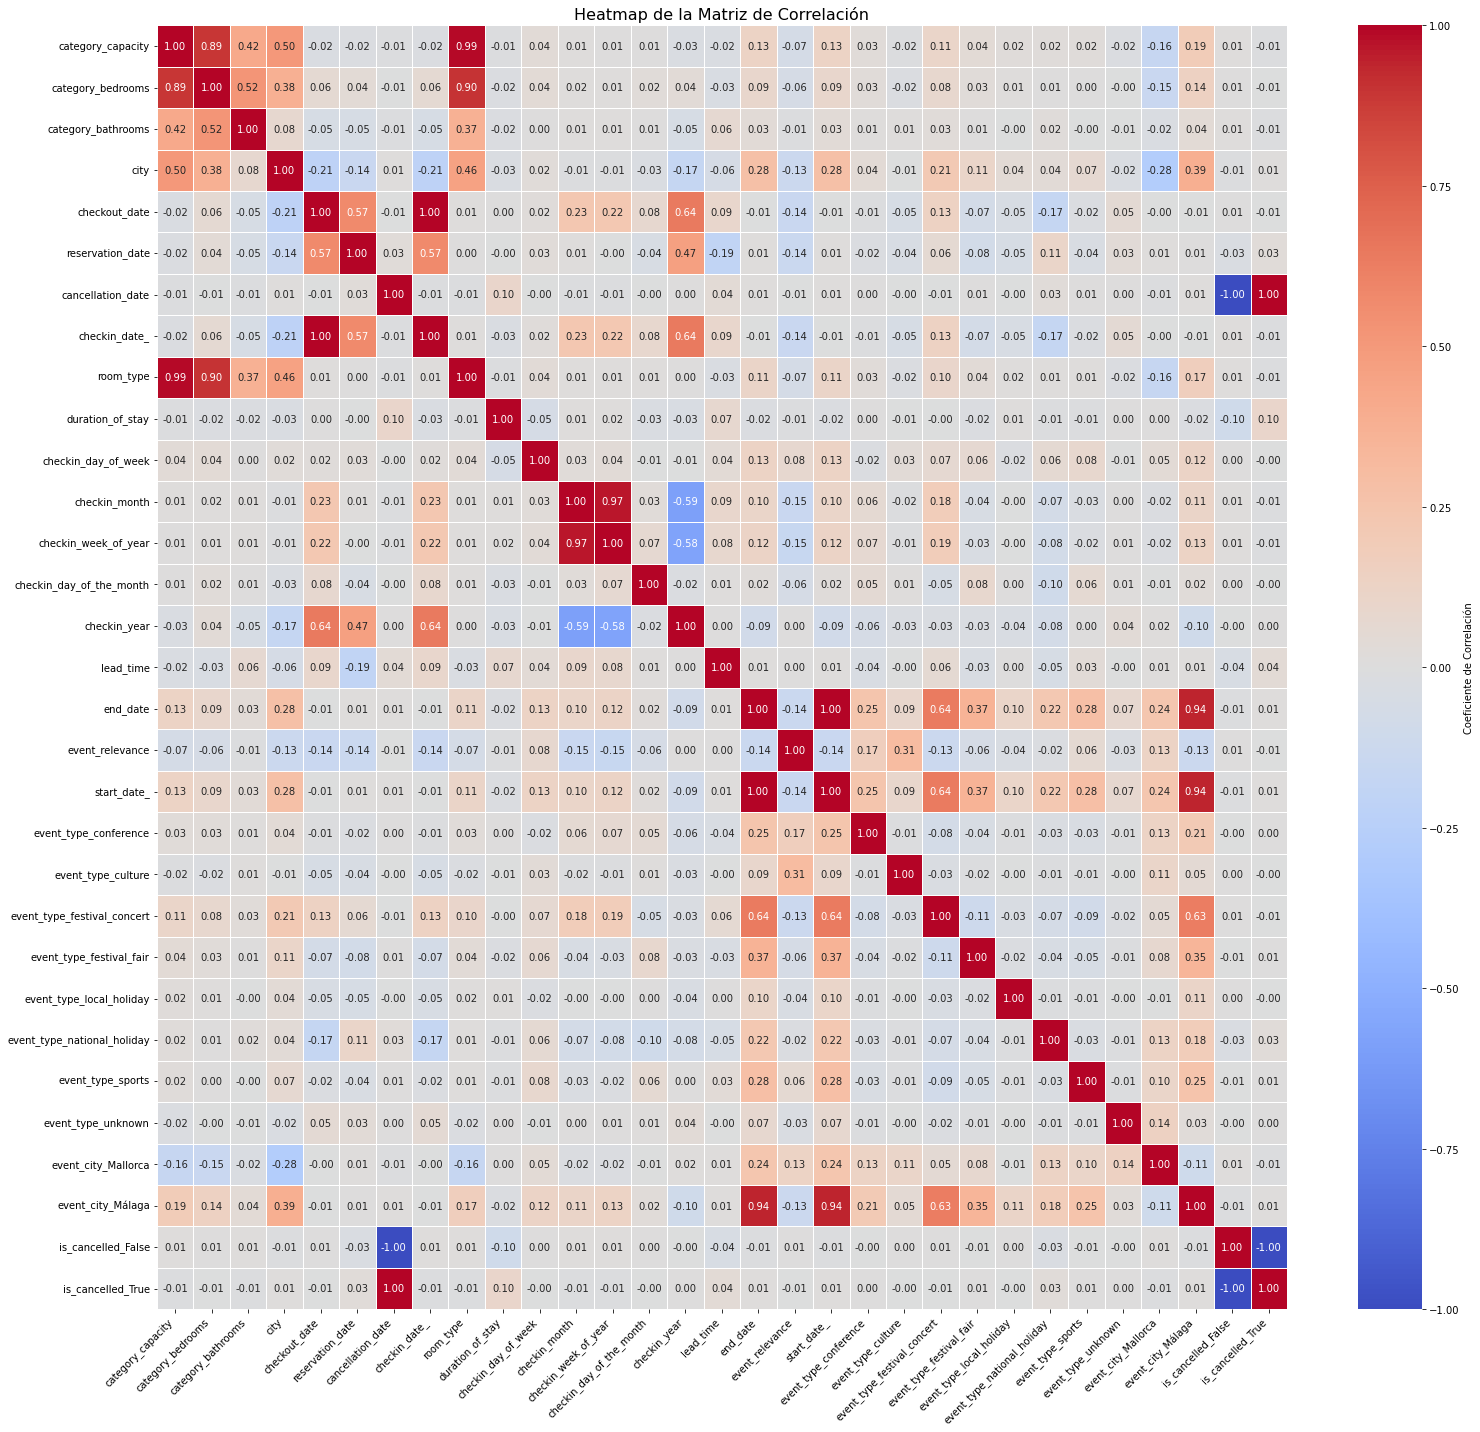

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt # Para mostrar el gráfico
# Se ha aumentado el tamaño de la figura para que sea más grande (antes era 10, 8)
plt.figure(figsize=(22, 20))

sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5,
            cbar_kws={'label': 'Coeficiente de Correlación'})

# Añadir un título al heatmap
plt.title('Heatmap de la Matriz de Correlación', fontsize=16)

# Asegurar que las etiquetas no se corten
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Ajusta el diseño para que todo quepa

# Mostrar el gráfico
plt.show()

## 📊 Heatmap of the Correlation Matrix

This heatmap titled **"Heatmap de la Matriz de Correlación"** visually represents the statistical correlation between multiple variables in the dataset, helping identify relationships between booking behavior, room characteristics, event details, and cancellations.

### 🧠 Notable Observations:

- **Booking Dates**:
  - Strong positive correlation (**0.97**) between `reservation_date` and `checkin_date` — bookings are often made close to the check-in day.

- **Event–City Relationship**:
  - A **moderate positive correlation (0.63 & 0.35)** between `event_city_Málaga` and `event_type_festival` (concert and fair) — indicating festivals are more common in Málaga.
  - A **low positive correlation (0.13 & 0.10)** between `event_city_Mallorca` and `event_type_national_holiday` and `event_type_sports`.


- **Room Characteristics**:
  - `category_capacity` and `category_bedrooms` show a **moderate positive correlation (0.41)** — larger rooms tend to have more bedrooms.

---

### ✅ Conclusion:
This correlation matrix helps uncover patterns between booking behaviors, room types, and events — essential for understanding cancellation trends, planning inventory, or enhancing forecasting models.


In [13]:
# Make a copy of the 'city' column and store it as 'city_'
# This preserves the original city labels before one-hot encoding
df_reservation_events['city_'] = df_reservation_events['city'].copy()

# One-hot encode the 'is_cancelled' and 'city' columns
# This converts each unique category into its own binary column (0 or 1)
df_reservation_events = pd.get_dummies(df_reservation_events, columns=['is_cancelled', 'city'], dtype=int)

# Group the dataset to calculate demand
# Group by check-in date, room type, and original city (city_)
# Count the number of records (reservations) per group to represent demand
df_demand = df_reservation_events.groupby(['checkin_date_', 'room_type', 'city_'])['room_type'].size().reset_index(name='demand')

# Display the resulting demand DataFrame
df_demand.head(5)


,checkin_date_,room_type,city_,demand
0,2019-01-01,0,Mallorca,3
1,2019-01-01,0,Málaga,4
2,2019-01-01,3,Málaga,18
3,2019-01-01,4,Málaga,4
4,2019-01-02,0,Mallorca,5


In [14]:
# One-hot encode the event_type column to create binary indicators for each type of event
df_events_agg = pd.get_dummies(df_reservation_events, columns=['event_type'], dtype=int)

# Extract only the one-hot encoded event columns
event_cols = [col for col in df_events_agg.columns if 'event_type_' in col]

# Define the keys by which we want to group event data
grouping_keys = ['checkin_date_', 'room_type', 'city_']

# Aggregate event data at the level of (checkin_date_, room_type, city_)
# Summing the one-hot encoded columns counts how many events of each type occurred for that date/room/city combo
df_events_summary = df_events_agg.groupby(grouping_keys)[event_cols].sum().reset_index()


In [15]:
# Start the model dataset with the demand DataFrame (already at correct granularity)
df_model = df_demand.copy()

# Aggregate numeric reservation-level features to match the daily granularity
# Average duration of stay, lead time, and max event relevance (since multiple events may exist on one day)
agg_features = df_reservation_events.groupby(['checkin_date_', 'room_type', 'city_']).agg(
    avg_duration_of_stay=('duration_of_stay', 'max'),
    avg_lead_time=('lead_time', 'max'),
    max_event_relevance=('event_relevance', 'max')
).reset_index()

# Merge aggregated reservation stats
df_model = df_model.merge(agg_features, on=['checkin_date_', 'room_type', 'city_'], how='left')

# Merge the aggregated event data
df_model = df_model.merge(df_events_summary, on=['checkin_date_', 'room_type', 'city_'], how='left')

# Add calendar/time features based on the check-in date
df_model['checkin_day_of_week'] = df_model['checkin_date_'].dt.dayofweek + 1
df_model['checkin_month'] = df_model['checkin_date_'].dt.month
df_model['checkin_week_of_year'] = df_model['checkin_date_'].dt.isocalendar().week.astype(int)
df_model['checkin_day_of_the_month'] = df_model['checkin_date_'].dt.day
df_model['checkin_year'] = df_model['checkin_date_'].dt.year

# Convert 'city_' to categorical dummy variables for modeling
df_model['city_'] = df_model['city_'].astype(str)
df_model = pd.get_dummies(df_model, columns=['city_'], prefix='city', dtype=int)

# Fill missing event relevance (NaN → 0) for rows with no events
df_model['max_event_relevance'] = df_model['max_event_relevance'].fillna(0)

# Sort for consistent time-series logic
df_model = df_model.sort_values(by=['checkin_date_', 'city_Málaga', 'city_Mallorca', 'room_type'])

# Lag features for avg_duration_of_stay and avg_lead_time by 28 days
df_model['avg_duration_of_stay'] = df_model.groupby(['city_Málaga', 'city_Mallorca', 'room_type'])['avg_duration_of_stay'].shift(28)
df_model['avg_lead_time'] = df_model.groupby(['city_Málaga', 'city_Mallorca', 'room_type'])['avg_lead_time'].shift(28)

# Lag features: shift demand backward by 28 days 
df_model['demand_lag_28'] = df_model.groupby(['city_Málaga', 'city_Mallorca', 'room_type'])['demand'].shift(28)
df_model['demand_lag_35'] = df_model.groupby(['city_Málaga', 'city_Mallorca', 'room_type'])['demand'].shift(35)
df_model['demand_lag_42'] = df_model.groupby(['city_Málaga', 'city_Mallorca', 'room_type'])['demand'].shift(42)
df_model['demand_lag_49'] = df_model.groupby(['city_Málaga', 'city_Mallorca', 'room_type'])['demand'].shift(49)

grouping_keys = ['city_Málaga', 'city_Mallorca', 'room_type']
lag_days = 28
window_sizes = [2, 3, 4, 5, 6, 7, 14, 21]
rolling_functions = {
    'max': 'max',
    'min': 'min',
    'mean': 'mean',
    'std': 'std',
    'median': 'median',
    'sum': 'sum',
    'skew': 'skew',
    'kurtosis': 'kurt',
    'count': 'count',
    'sem': 'sem'
}

# Calcular las características de las ventanas móviles
for func_name, func_method in rolling_functions.items():
    for window in window_sizes:
        column_name = f'demand_rolling_{func_name}_{window}_28'
        df_model[column_name] = df_model.groupby(grouping_keys)['demand'].shift(lag_days).rolling(window=window, min_periods=1).agg(func_method)


for window in window_sizes:
    mean_col = f'demand_rolling_mean_{window}_{lag_days}'
    std_col = f'demand_rolling_std_{window}_{lag_days}'
    z_col = f'demand_rolling_zscore_{window}_{lag_days}'

    df_model[z_col] = (
        (df_model['demand'].shift(lag_days) - df_model[mean_col]) / df_model[std_col]
    )


print(df_model.groupby('room_type')['demand'].describe())

df_model['weekend'] = [1 if dia == 6 or dia == 7 else 0 for dia in df_model['checkin_day_of_week']]
df_model = pd.get_dummies(df_model, columns=['room_type'], dtype=int)
df_model.drop(['checkin_year','event_type_local_holiday'], axis=1, inplace=True)


# Fill any remaining NaNs (from lags/rolls) with 0
df_model.fillna(0, inplace=True)

# Preview the first 10 rows
df_model.head(10)

           count       mean        std  min  25%   50%   75%   max
room_type                                                         
0          822.0   4.965937   2.761984  1.0  3.0   5.0   6.0  24.0
1          130.0   5.884615   3.188241  1.0  3.0   6.0   8.0  15.0
2          222.0   1.288288   0.473504  1.0  1.0   1.0   2.0   3.0
3          557.0  16.294434  10.704140  1.0  8.0  14.0  22.0  76.0
4          371.0   3.897574   2.729275  1.0  2.0   3.0   6.0  21.0


,checkin_date_,demand,avg_duration_of_stay,avg_lead_time,max_event_relevance,event_type_conference,event_type_culture,event_type_festival_concert,event_type_festival_fair,event_type_national_holiday,event_type_sports,event_type_unknown,checkin_day_of_week,checkin_month,checkin_week_of_year,checkin_day_of_the_month,city_Mallorca,city_Málaga,demand_lag_28,demand_lag_35,demand_lag_42,demand_lag_49,demand_rolling_max_2_28,demand_rolling_max_3_28,demand_rolling_max_4_28,demand_rolling_max_5_28,demand_rolling_max_6_28,demand_rolling_max_7_28,demand_rolling_max_14_28,demand_rolling_max_21_28,demand_rolling_min_2_28,demand_rolling_min_3_28,demand_rolling_min_4_28,demand_rolling_min_5_28,demand_rolling_min_6_28,demand_rolling_min_7_28,demand_rolling_min_14_28,demand_rolling_min_21_28,demand_rolling_mean_2_28,demand_rolling_mean_3_28,demand_rolling_mean_4_28,demand_rolling_mean_5_28,demand_rolling_mean_6_28,demand_rolling_mean_7_28,demand_rolling_mean_14_28,demand_rolling_mean_21_28,demand_rolling_std_2_28,demand_rolling_std_3_28,demand_rolling_std_4_28,demand_rolling_std_5_28,demand_rolling_std_6_28,demand_rolling_std_7_28,demand_rolling_std_14_28,demand_rolling_std_21_28,demand_rolling_median_2_28,demand_rolling_median_3_28,demand_rolling_median_4_28,demand_rolling_median_5_28,demand_rolling_median_6_28,demand_rolling_median_7_28,demand_rolling_median_14_28,demand_rolling_median_21_28,demand_rolling_sum_2_28,demand_rolling_sum_3_28,demand_rolling_sum_4_28,demand_rolling_sum_5_28,demand_rolling_sum_6_28,demand_rolling_sum_7_28,demand_rolling_sum_14_28,demand_rolling_sum_21_28,demand_rolling_skew_2_28,demand_rolling_skew_3_28,demand_rolling_skew_4_28,demand_rolling_skew_5_28,demand_rolling_skew_6_28,demand_rolling_skew_7_28,demand_rolling_skew_14_28,demand_rolling_skew_21_28,demand_rolling_kurtosis_2_28,demand_rolling_kurtosis_3_28,demand_rolling_kurtosis_4_28,demand_rolling_kurtosis_5_28,demand_rolling_kurtosis_6_28,demand_rolling_kurtosis_7_28,demand_rolling_kurtosis_14_28,demand_rolling_kurtosis_21_28,demand_rolling_count_2_28,demand_rolling_count_3_28,demand_rolling_count_4_28,demand_rolling_count_5_28,demand_rolling_count_6_28,demand_rolling_count_7_28,demand_rolling_count_14_28,demand_rolling_count_21_28,demand_rolling_sem_2_28,demand_rolling_sem_3_28,demand_rolling_sem_4_28,demand_rolling_sem_5_28,demand_rolling_sem_6_28,demand_rolling_sem_7_28,demand_rolling_sem_14_28,demand_rolling_sem_21_28,demand_rolling_zscore_2_28,demand_rolling_zscore_3_28,demand_rolling_zscore_4_28,demand_rolling_zscore_5_28,demand_rolling_zscore_6_28,demand_rolling_zscore_7_28,demand_rolling_zscore_14_28,demand_rolling_zscore_21_28,weekend,room_type_0,room_type_1,room_type_2,room_type_3,room_type_4
0,2019-01-01,3,0.0,0.0,2.0,0,0,0,0,3,0,0,2,1,1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
1,2019-01-01,4,0.0,0.0,2.0,0,0,0,0,4,0,0,2,1,1,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
2,2019-01-01,18,0.0,0.0,2.0,0,0,0,0,18,0,0,2,1,1,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [16]:
# Preparing data for CastBoost

# Target variable: 'demand' — the number of reservations
y = df_model['demand']

# Feature set: start with all columns in df_model
X = df_model

# Define cut-off date to separate train and test sets
cut_off_date = pd.to_datetime('2020-01-01')
starting_date = pd.to_datetime('2019-01-28')


X_train = X[(df_model['checkin_date_'] <= cut_off_date) & (df_model['checkin_date_'] > starting_date)]
y_train = y[(df_model['checkin_date_'] <= cut_off_date) & (df_model['checkin_date_'] > starting_date)]

X_test = X[df_model['checkin_date_'] > cut_off_date]
y_test = y[df_model['checkin_date_'] > cut_off_date]


# Drop Columns That Shouldn't Be in the Model
X_train = X_train.drop(columns=['demand', 'checkin_date_'])
X_test = X_test.drop(columns=['demand', 'checkin_date_'])


print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Columnas de X:", X_train.columns.tolist())

# # Add missing columns to test set with value 0
# missing_cols_in_test = set(X_train.columns) - set(X_test.columns)
# for c in missing_cols_in_test:
#     X_test[c] = 0

# # Ensure test columns match train columns (same order)
# X_test = X_test[X_train.columns]


Shape de X_train: (1608, 114)
Shape de X_test: (377, 114)
Columnas de X: ['avg_duration_of_stay', 'avg_lead_time', 'max_event_relevance', 'event_type_conference', 'event_type_culture', 'event_type_festival_concert', 'event_type_festival_fair', 'event_type_national_holiday', 'event_type_sports', 'event_type_unknown', 'checkin_day_of_week', 'checkin_month', 'checkin_week_of_year', 'checkin_day_of_the_month', 'city_Mallorca', 'city_Málaga', 'demand_lag_28', 'demand_lag_35', 'demand_lag_42', 'demand_lag_49', 'demand_rolling_max_2_28', 'demand_rolling_max_3_28', 'demand_rolling_max_4_28', 'demand_rolling_max_5_28', 'demand_rolling_max_6_28', 'demand_rolling_max_7_28', 'demand_rolling_max_14_28', 'demand_rolling_max_21_28', 'demand_rolling_min_2_28', 'demand_rolling_min_3_28', 'demand_rolling_min_4_28', 'demand_rolling_min_5_28', 'demand_rolling_min_6_28', 'demand_rolling_min_7_28', 'demand_rolling_min_14_28', 'demand_rolling_min_21_28', 'demand_rolling_mean_2_28', 'demand_rolling_mean_3_28'

## GRID

In [17]:
# import pandas as pd
# import numpy as np
# from catboost import CatBoostRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score

# # 1. Definir la rejilla de hiperparámetros para CatBoost
# param_grid = {
#     'iterations': [150, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'depth': [5, 6, 7, 8],
#     'subsample': [0.6, 0.8, 1.0]
# }

# # 2. Instanciar el modelo base de CatBoost
# cat_model = CatBoostRegressor(
#     loss_function='RMSE',
#     random_seed=42,
#     verbose=0  # Silencia la salida durante GridSearchCV
# )

# # 3. Configurar GridSearchCV
# grid_search = GridSearchCV(
#     estimator=cat_model,
#     param_grid=param_grid,
#     cv=3,
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1,
#     verbose=2
# )

# # 4. Ejecutar la búsqueda
# print("Iniciando GridSearchCV con CatBoost...")
# grid_search.fit(X_train, y_train)

# # 5. Resultados del mejor modelo
# print("\nMejores parámetros encontrados:")
# print(grid_search.best_params_)
# print(f"\nMejor RMSE (en validación cruzada): {-grid_search.best_score_:.2f}")

# # 6. Evaluar en el conjunto de prueba
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # 7. Métricas finales
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2 = r2_score(y_test, y_pred)

# print(f"\nResultados del mejor modelo en el conjunto de prueba:")
# print(f"RMSE: {rmse:.2f}")
# print(f"R-squared: {r2:.2f}")

# # 8. Importancia de variables
# print("\nImportancia de las características del mejor modelo:")
# feature_importances = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': best_model.get_feature_importance()
# }).sort_values(by='importance', ascending=False)
# print(feature_importances)


## CastBoost

## ✅ Why Choose CastBoost for Time Series Forecasting

### 🧩 Handling Complex Regressors and Interactions
CastBoost effectively handles multiple variables (such as city, room type, events) and captures **non-linear interactions** between them.  
> *Example: The impact of an event can vary depending on the city or room type.*

---

### 📈 Robustness to Non-Linear Relationships
It can model complex data patterns beyond the basic **linear or additive trends** that models like Prophet are limited to.

---

### 🛠️ Feature Engineering Flexibility
CastBoost allows the easy integration of **manually crafted features**, such as:
- **Lagged variables** (previous demand)
- **Rolling windows**
- **Date and time breakdowns** (weekday, month, etc.)  
These features are highly effective in time series tasks.

---

### 🚨 Robustness to Outliers
Tree-based models like CastBoost are less sensitive to outliers in the input data —  
> Useful when there are unusual peaks in bookings or demand.

---

### ⚡ Performance & Scalability
CastBoost is known for its **training efficiency and speed**, even with large datasets.

---

### 🏆 Proven High Accuracy
It has demonstrated excellent results in **industry use-cases** and **machine learning competitions**.

---

### ✅ Summary

> **I choose CastBoost when I need higher accuracy, the ability to capture complex and non-linear relationships, and I'm ready to invest in advanced feature engineering that goes beyond basic time-series decomposition.**


In [18]:
from catboost import CatBoostRegressor

# Crear y entrenar el modelo CatBoost
cat_model = CatBoostRegressor(
    iterations=150,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=0  # Cambia a verbose=100 si quieres ver el entrenamiento en consola
)

# Entrenar el modelo
cat_model.fit(X_train, y_train)

# Predecir en el conjunto de test
y_pred = cat_model.predict(X_test)

# Aplicar los factores correctivos por room_type como antes
room_type_cols = [col for col in X_test.columns if col.startswith('room_type_')]
room_types = np.argmax(X_test[room_type_cols].values, axis=1)

correction_factors = {
    0: 1.15,
    1: 1.2,
    2: 1.05,
    3: 1.1,
    4: 1.05
}

y_pred = np.array([y_pred[i] * correction_factors[room_type] for i, room_type in enumerate(room_types)])

# Evaluar desempeño
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

# Importancia de variables
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': cat_model.get_feature_importance()
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importances)

import joblib
joblib.dump(cat_model, 'modelo_demanda_catboost.joblib')
print("\nModel saved successfully as 'modelo_demanda_catboost.joblib'!")




RMSE (Root Mean Squared Error): 4.83
R-squared: 0.63

Feature Importance:
                         feature  importance
112                  room_type_3   34.917596
17                 demand_lag_35    6.723033
5    event_type_festival_concert    5.826758
19                 demand_lag_49    4.498711
1                  avg_lead_time    4.166997
..                           ...         ...
49       demand_rolling_std_7_28    0.000000
68      demand_rolling_skew_2_28    0.000000
24       demand_rolling_max_6_28    0.000000
88     demand_rolling_count_6_28    0.000000
9             event_type_unknown    0.000000

[114 rows x 2 columns]

Model saved successfully as 'modelo_demanda_catboost.joblib'!


## 📊 Model Evaluation & Feature Importance (CastBoost)

### ✅ Model Performance

- **RMSE (Root Mean Squared Error):** `4.83`  
  This means that, on average, the model's predictions are off by around **4 room bookings** per data point. Lower is better.

- **R-squared (R²):** `0.63`  
  This indicates that the model explains **62% of the variance** in the demand data. A value close to 1.0 implies good predictive power.

> 🔸 **Temporal features**, especially rolling statistics and recent demand lags, are highly predictive of future demand.  
> 🔸 **City-specific** binary indicators (`city_Málaga`, `city_Mallorca`) are also influential.  
> 🔸 **Event-related features** (e.g., holidays, festivals, conferences) significantly affect demand.

---

### 💾 Model Saved

- The trained CastBoost model has been successfully saved as:  
  **`modelo_demanda_catboost.joblib`**

This model is now ready for:
- Forecasting future demand
- Deployment in a demand estimation pipeline
- Further experimentation or hyperparameter tuning

---


In [21]:
import pandas as pd
import plotly.express as px

# Asumo que 'y_test' y 'y_pred' ya existen en tu entorno
# y están correctamente alineados.

# Crear el DataFrame con los resultados
results = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
results['residual'] = results['actual'] - results['predicted']

# Crear el gráfico de dispersión interactivo con Plotly Express
fig = px.scatter(
    results, 
    x='actual', 
    y='residual',
    title='Análisis de Residuos (Plotly)',
    labels={
        'actual': 'Demanda Real',
        'residual': 'Residuo (Real - Predicho)'
    },
    template='plotly_white', # Usamos una plantilla limpia
    trendline='ols', # Añade una línea de tendencia para ver si hay patrones
    trendline_color_override='lightgray'
)

# Añadir la línea horizontal en y=0 para marcar el error cero
fig.add_hline(
    y=0, 
    line_dash="dash", 
    line_color="red",
    annotation_text="Error Cero", 
    annotation_position="bottom right"
)

# Ajustar el tamaño de la figura
fig.update_layout(
    height=500,
    width=1000
)


# Mostrar el gráfico
fig.show()

## 📉 Residual Plot Interpretation

This plot shows the error of your model (**Residual = Actual Demand - Prediction**) as a function of the actual demand value.

---

### 🔍 Main Observation: **Heteroscedasticity (Cone Shape)**

- **What you see**: The residuals are not randomly scattered around the red "Zero Error" line. Instead, they form a cone that opens to the right.
- **What it means**: The model’s error increases as actual demand increases.  
  - For **low demand values** (e.g., below 15), the model performs quite well — errors are small and tightly clustered.
  - For **high demand values** (e.g., above 30), the errors become much larger and more unpredictable.
  - This indicates the model struggles significantly to predict **demand spikes**.

---

### ⚠️ Secondary Observation: **Model Bias (Gray Trend Line)**

- **What you see**: The light gray trend line of the residuals has a **positive slope**.
- **What it means**: This shows **systematic bias** in the model.  
  - The model tends to **underestimate demand**, and this underestimation worsens as actual demand increases.
  - As a result, most large errors are **positive** (Actual > Prediction).

---

### 🧠 Conclusion & Next Steps

The diagnosis is clear:  
Your model lacks the predictive power to accurately capture **high-demand days**, leading to consistent underestimation and increasing error for peak scenarios.

✅ **Next steps we might consider**:
- Engineer features that better capture demand surges (e.g., proximity to holidays, special events, lagged peaks).
- Try ensemble models or non-linear architectures.
- Train a separate model specialized for high-demand periods.


In [22]:
# 1. Cargar el modelo desde el archivo
loaded_model = joblib.load('modelo_demanda_catboost.joblib')
print("Modelo cargado exitosamente.")

# 2. Realizar predicciones con el modelo cargado
prediction = loaded_model.predict(X_test)

# 3. Calcular el RMSE para evaluar el desempeño
rmse = np.sqrt(mean_squared_error(y_test, prediction))
print(f"RMSE: {rmse:.2f}")


Modelo cargado exitosamente.
RMSE: 4.89
